<a href="https://colab.research.google.com/github/MoonOrchid11/Covid19-Analysis/blob/master/Covid_19_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Covid19 Analysis***
The whole world now is dealing with Coronavirus and it badly affects everywhere.  We were thinking that we can make an investigation about COVID-19 by calculating data of how it starts and how it spreads, comparison of China where the COVID-19 originally originated from with the Rest of the World. Perform predictions in order to study the impact and spread of the COVID-19 in comming days.

**Done by**: BOURRAR Farah -MEJAIT Asmae- HAJJI Abderrahmane

In [0]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline

In [0]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/04-12-2020.csv')

In [0]:
confirmed_df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Saint Pierre and Miquelon,France,46.885200,-56.315900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1
260,NaN,South Sudan,6.877000,31.307000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,2,3,4,4,4,4
261,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,6,6
262,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4


**visualisation du dataset** 

In [0]:
unique_countries =  list(confirmed_df['Country/Region'].unique())
ccc= []
cdc = [] 
cac = []
crc = []
cmr = [] 

no_cases = []
for i in unique_countries:
    cases = latest_data[latest_data['Country_Region']==i]['Confirmed'].sum()
    if cases > 0:
        ccc.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)


unique_countries = [k for k, v in sorted(zip(unique_countries, ccc), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_countries)):
    ccc[i] = latest_data[latest_data['Country_Region']==unique_countries[i]]['Confirmed'].sum()
    cdc.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Deaths'].sum())
    crc.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Recovered'].sum())
    cac.append(ccc[i] - cdc[i] - crc[i])
    cmr.append(cdc[i]/ccc[i])
country_df = pd.DataFrame({'Country Name': unique_countries, 'Number of Confirmed Cases': ccc,
                          'Number of Deaths': cdc, 'Number of Recoveries' : crc, 
                          'Number of Active Cases' : cac,
                          'Mortality Rate': cmr})


country_df.style.background_gradient(cmap='Oranges')

,Country Name,Number of Confirmed Cases,Number of Deaths,Number of Recoveries,Number of Active Cases,Mortality Rate
0,US,555313,22020,32988,500305,0.039653
1,Spain,166831,17209,62391,87231,0.103152
2,Italy,156363,19899,34211,102253,0.127262
3,France,133670,14412,27469,91789,0.107818
4,Germany,127854,3022,60300,64532,0.023636
5,United Kingdom,85206,10629,626,73951,0.124745
6,China,83134,3343,77956,1835,0.040212
7,Iran,71686,4474,43894,23318,0.062411
8,Turkey,56956,1198,3446,52312,0.021034
9,Belgium,29647,3600,6463,19584,0.121429


In [0]:
##Pretraitement
cols = confirmed_df.keys()

confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]
confirmed

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,...,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,...,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1
260,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,2,3,4,4,4,4
261,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,6,6
262,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4


In [0]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
total_recovered = [] 
total_active = [] 



for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)

In [0]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)


**svm-svr model**

In [0]:
Xtrainc, Xtestc, ytrainc, ytestc = train_test_split(days_since_1_22, world_cases, test_size=0.05, shuffle=False)

In [0]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

In [0]:
#svm-svr
svmc = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=5, C=0.1)
svmc.fit(Xtrainc, ytrainc)
svmp = svmc.predict(future_forcast)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE: 44788.57311301977
MSE: 3933626241.5457716


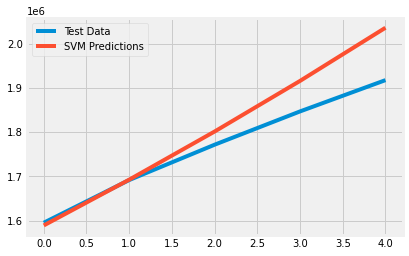

In [0]:
#check against testing data
svmtp = svmc.predict(Xtestc)
plt.plot(ytestc)
plt.plot(svmtp)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svmtp, ytestc))
print('MSE:',mean_squared_error(svmtp, ytestc))

In [0]:
poly = PolynomialFeatures(degree=5)
poly_X_train_confirmed = poly.fit_transform(Xtrainc)
poly_X_test_confirmed = poly.fit_transform(Xtestc)
poly_future_forcast = poly.fit_transform(future_forcast)

In [0]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, ytrainc)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, ytestc))
print('MSE:',mean_squared_error(test_linear_pred, ytestc))

MAE: 149034.49841793254
MSE: 26340945857.389168


In [0]:
print(linear_model.coef_)

[[ 2.26116832e+04 -1.22438652e+04  1.51202532e+03 -5.37065682e+01
   7.16366674e-01 -2.64170483e-03]]


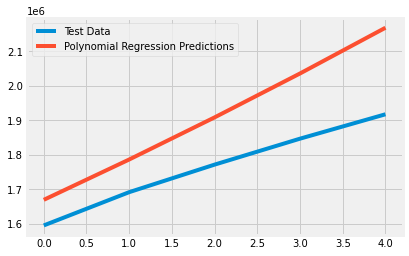

In [0]:
plt.plot(ytestc)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

**prediction plots**

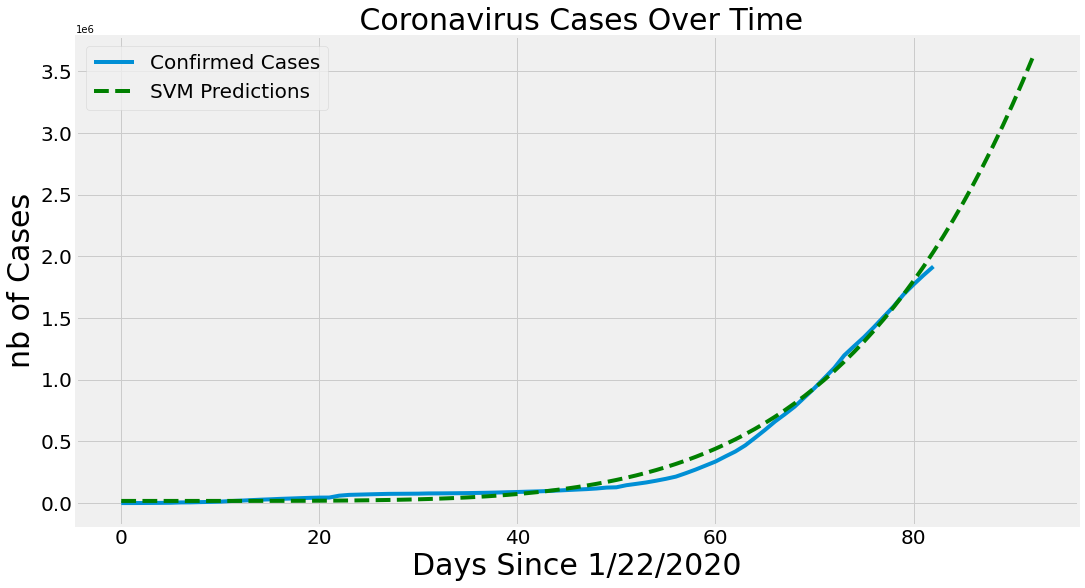

In [0]:
def ppred(x, y, pred, algo_name, color):
    plt.figure(figsize=(16, 9))
    plt.plot(x, y)
    plt.plot(future_forcast, pred, linestyle='dashed', color=color)
    plt.title(' Coronavirus Cases Over Time', size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('nb of Cases', size=30)
    plt.legend(['Confirmed Cases', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()


ppred(adjusted_dates, world_cases, svmp, 'SVM Predictions', 'green')


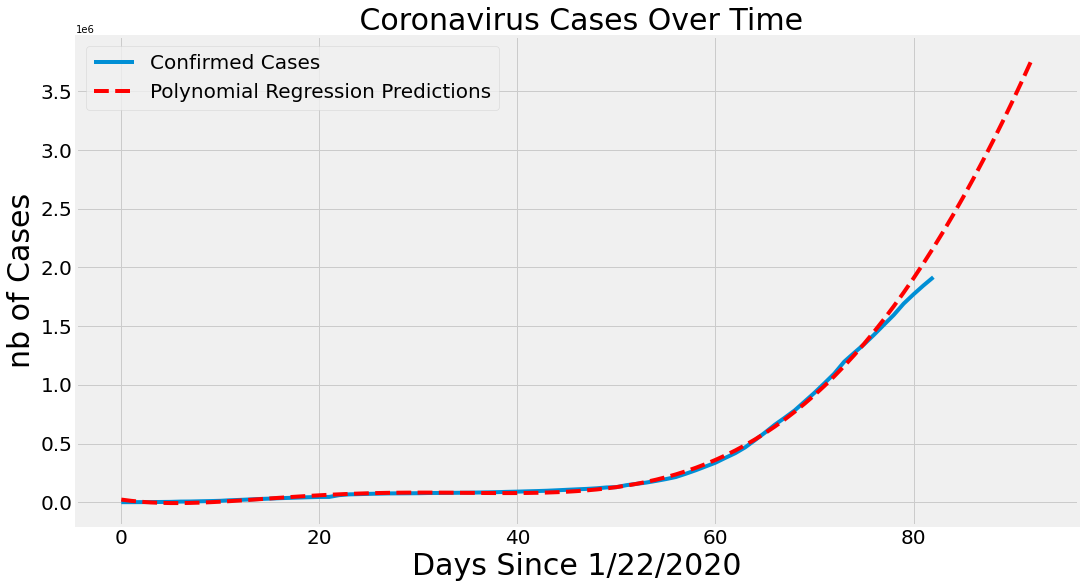

In [0]:
ppred(adjusted_dates, world_cases, linear_pred, 'Polynomial Regression Predictions', 'red')

In [0]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [0]:
# Future predictions using SVM 
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'SVM Predicted num of Confirmed Cases Worldwide': np.round(svmp[-10:])})
svm_df

,Date,SVM Predicted num of Confirmed Cases Worldwide
0,04/14/2020,2161706.0
1,04/15/2020,2294002.0
2,04/16/2020,2432750.0
3,04/17/2020,2578183.0
4,04/18/2020,2730541.0
5,04/19/2020,2890066.0
6,04/20/2020,3057010.0
7,04/21/2020,3231628.0
8,04/22/2020,3414181.0
9,04/23/2020,3604938.0


In [0]:
# Future predictions using polynomial regression

linear_pred = linear_pred.reshape(1,-1)[0]
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Polynomial Predicted num of Confirmed Cases Worldwide': np.round(linear_pred[-10:])})
svm_df

,Date,Polynomial Predicted num of Confirmed Cases Worldwide
0,04/14/2020,2305773.0
1,04/15/2020,2448800.0
2,04/16/2020,2597123.0
3,04/17/2020,2750742.0
4,04/18/2020,2909645.0
5,04/19/2020,3073811.0
6,04/20/2020,3243208.0
7,04/21/2020,3417795.0
8,04/22/2020,3597519.0
9,04/23/2020,3782314.0


**Morocco dataset**

In [0]:
#morocco dataset
morocco_cases = [] 
morocco_recoveries = [] 
morocco_deaths = []
for i in dates: 
    morocco_cases.append(confirmed_df[confirmed_df['Country/Region']=='Morocco'][i].sum())
    morocco_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Morocco'][i].sum())
    morocco_deaths.append(deaths_df[deaths_df['Country/Region']=='Morocco'][i].sum())

In [0]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
morocco_cases = np.array(morocco_cases).reshape(-1, 1)
morocco_recoveries = np.array(morocco_recoveries).reshape(-1, 1)
morocco_deaths = np.array(morocco_deaths).reshape(-1, 1)

In [0]:
XtrainC2, XtestC2, ytrainC2, ytestC2 = train_test_split(days_since_1_22, morocco_cases, test_size=0.05, shuffle=False)

In [0]:
#svm on morocco dataset
svm_confirmed2 = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=0.1,degree=6, C=0.01)
svm_confirmed2.fit(XtrainC2, ytrainC2)
svm_predM = svm_confirmed2.predict(future_forcast)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE: 66.12975740595785
MSE: 4744.776808718621


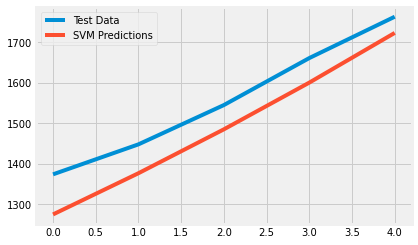

In [0]:
svm_test_pred2 = svm_confirmed2.predict(XtestC2)
plt.plot(ytestC2)
plt.plot(svm_test_pred2)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred2, y_test_confirmed2))
print('MSE:',mean_squared_error(svm_test_pred2, y_test_confirmed2))

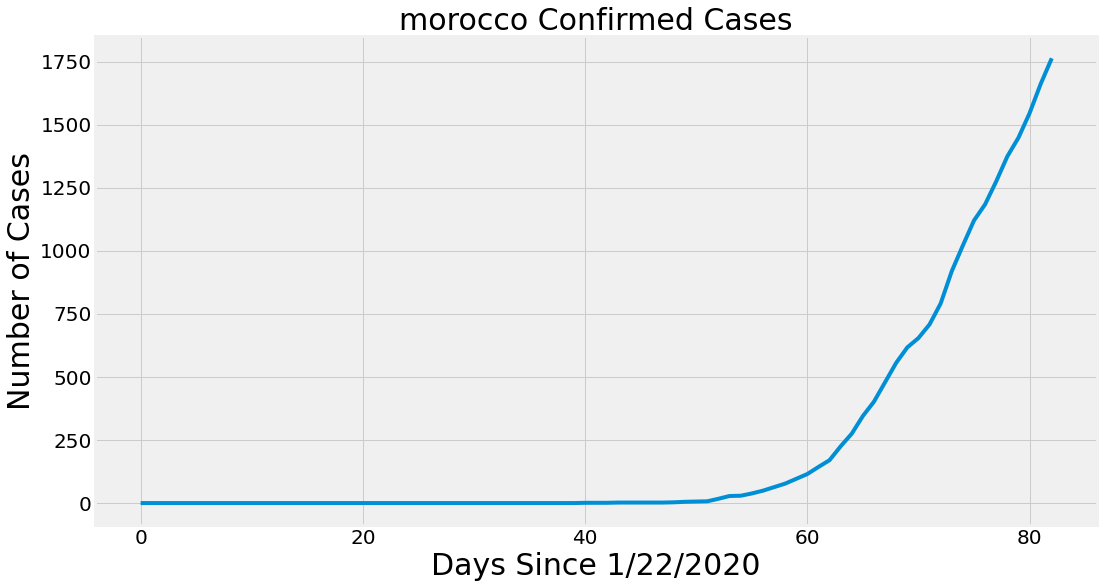

In [0]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, morocco_cases)
plt.title('{} Confirmed Cases'.format('morocco'), size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Number of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

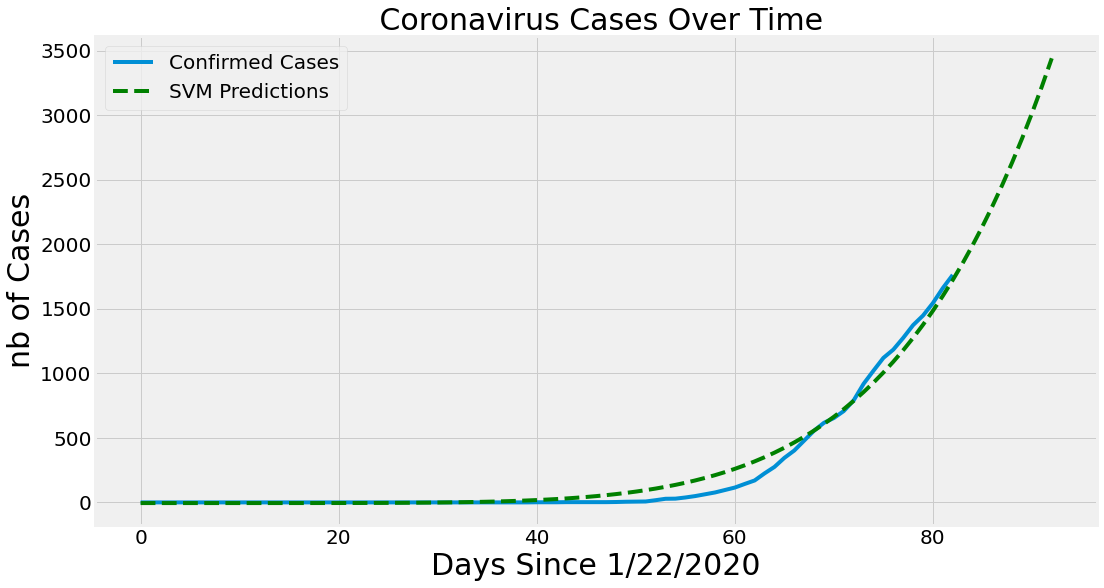

In [0]:
ppred(adjusted_dates, morocco_cases, svm_predM, 'SVM Predictions', 'green')